# Load Data + Imports

In [1]:
# import packages
import os
import cv2
import numpy as np;
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album

from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Quantify Image Features

In [ ]:
class ImageFeatures:
	def __init__(self, bins):
		# store the number of bins the histogram will use
		self.bins = bins
	def getHist(self, image):
		# compute a 3D histogram in the RGB colorspace,
		# then normalize the histogram so that images
		# with the same content, but either scaled larger
		# or smaller will have (roughly) the same histogram
		hist = cv2.calcHist([image], [0, 1, 2],
			None, self.bins, [0, 256, 0, 256, 0, 256])
		hist = cv2.normalize(hist)
		# return out 3D histogram as a flattened array
		return hist.flatten()
	def getMean(self, image):
		# return the mean of each channel
		return cv2.mean(image)[:3]
	def getMeanStd(self, image):
		return cv2.meanStdDev(image)[:3]

In [39]:
imgs_dir = "/Users/huayinluo/Desktop/code/CaTracking/original"
all_imgs = []
videos = ['11408', '11409', "11410", '11411', '11413', '11414', '11415']

for video in videos:
    imgs = [os.path.join(imgs_dir, video, img) for img in os.listdir(os.path.join(imgs_dir, video))[:20] if img.endswith(".png")]
    all_imgs += imgs
    print("Done with video", video)

Done with video 11408
Done with video 11409
Done with video 11410
Done with video 11411
Done with video 11413
Done with video 11414
Done with video 11415


In [41]:
len(all_imgs)

140

In [44]:
img_sizes = set([cv2.imread(img_path).shape[:2] for img_path in all_imgs])

In [45]:
img_sizes

{(366, 352),
 (391, 327),
 (421, 454),
 (484, 377),
 (506, 287),
 (538, 305),
 (546, 340)}

In [46]:
max_width = max([x for (y, x) in img_sizes])
max_height = max([y for (y, x) in img_sizes])
print(img_sizes)
print(max_width, max_height)

{(366, 352), (484, 377), (506, 287), (538, 305), (391, 327), (546, 340), (421, 454)}
454 546


### Change images to same shape

(484, 377, 3)

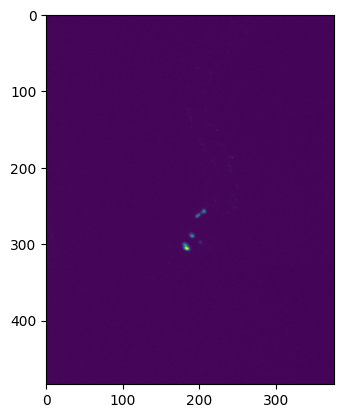

In [49]:
img = cv2.cvtColor(cv2.imread(all_imgs[0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape # height=484, width=377, channel=3

In [59]:
PURPLE = (69, 6, 90)

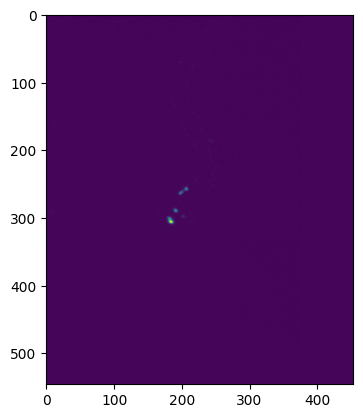

In [61]:
img_w_padding = cv2.copyMakeBorder(img, 0, max_height-img.shape[0], 0, max_width-img.shape[1], borderType=cv2.BORDER_CONSTANT, value=PURPLE)
plt.imshow(img_w_padding)

Number of contours: 2
2
(9, 1, 2)
114 83
113 84
113 86
115 88
116 88
118 90
118 92
121 92
122 91
122 89
121 88
120 88
119 87
119 85
118 84
118 83


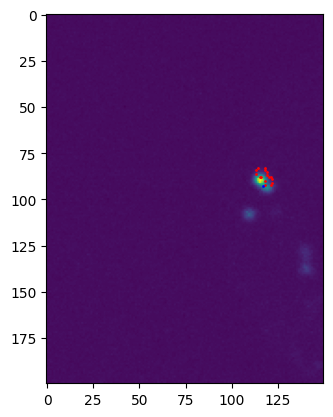

In [56]:
img_grey = cv2.imread(f"{original_dir}/11408/1.png", cv2.IMREAD_GRAYSCALE)
im_gauss = cv2.GaussianBlur(img_grey, (5, 5), 0) # "smoothing" the image with Gaussian Blur

thresh = cv2.adaptiveThreshold(im_gauss,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,-2) # thresholding
# Find contours
cont, hierarchy = cv2.findContours(thresh, 
                        cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE # only stores necessary points to define contour (avoids redundancy, saves memory)
                        )
cont_filtered = []
for con in cont: 
    area = cv2.contourArea(con) # calculate area, filter for contours above certain size
    if area>20: # chosen by trial/error
        cont_filtered.append(con)    
print(f"Number of contours: {len(cont_filtered)}")
print(len(cont_filtered))
print(cont_filtered[0].shape) # each contour is a numpy array of boundary points (ie. 9 boundary points here)
plt.imshow(imgs[0, 0, :200, :150])
for i in cont_filtered[1]:
    x, y = i.ravel()
    print(x, y)
    plt.plot(x, y, 'ro', markersize=1)
actx, acty = ava[0]
plt.plot(actx, acty, 'bo', markersize=1)

### Contour Features

In [57]:
cnt = cont_filtered[0]

In [58]:
cv2.moments(cnt)

{'m00': 26.0,
 'm10': 2841.6666666666665,
 'm01': 2693.833333333333,
 'm20': 310638.6666666666,
 'm11': 294424.1666666666,
 'm02': 279156.5,
 'm30': 33964111.9,
 'm21': 32185385.78333333,
 'm12': 30510799.716666665,
 'm03': 28933732.85,
 'mu20': 59.07264957262669,
 'mu11': 1.997863247874193,
 'mu02': 51.191239316307474,
 'mu30': -14.02318648993969,
 'mu21': -4.578654390221345,
 'mu12': 11.845337493248735,
 'mu03': 6.455755524337292,
 'nu20': 0.08738557629086789,
 'nu11': 0.002955419005731055,
 'nu02': 0.07572668537915307,
 'nu30': -0.004068303456699659,
 'nu21': -0.0013283254484374098,
 'nu12': 0.0034364819653600106,
 'nu03': 0.0018728961876183588}

In [61]:
area = cv2.contourArea(cnt)
print(area)
cv2.contourArea(cont_filtered[1])

26.0


43.5

### Color Features

In [ ]:
# pixel values of the image
raw=img.flatten()
print(raw.shape) # (546204,)
raw

(547404,)


array([70, 12, 95, ..., 70, 14, 97], dtype=uint8)

In [ ]:
# mean of the channels
means=cv2.mean(img)[:3]
means

(70.09529890172523, 12.280229958129645, 95.2008406953548)

In [ ]:
# mean and standard deviation of the channels
stats = np.concatenate(cv2.meanStdDev(img)).flatten()
stats

array([70.0952989 , 12.28022996, 95.2008407 ,  1.0842824 ,  3.75480051,
        2.67148634])

In [ ]:
# histogram of the distributions for each channel
hist = cv2.calcHist([img], # list of images (need to be same size)
                    [0, 1, 2], # the channels we want to compute
                    None, # optional mask
                    [8, 8, 8], # the number of bins for each channel
                    [0, 256, 0, 256, 0, 256]).flatten() # range of possible pixel values for each channel
print(hist.shape)
hist

(512,)


array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000